<a name="section-taskA"></a><h2 style="color:rgb(0,120,170)">1. Words Similarity and Nearest Neighbors</h2>

In [312]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

### Loading a word embedding (WE) model

Pre-trained word embedding model: **GloVe** <br>
Kind: **"Common Crawl - glove.840B.300d.zip"**

In [37]:
we = pd.read_csv('./glove.840B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in we.T.items()}

### Calculating word-to-word similarities

Source words: 

1. **Revolutionary**
2. **Sculpture**
3. **Vain**
4. **Empirical**
5. **Gravity**


Target Words:

- **Revolutionary**: "radical", "revolution", "rebel", "independence", "subversive", "politics"
- **Sculpture**: "sculpt", "sculptor", "statue", "art", "carving", "museum"
- **Vain**: "futile", "fruitless", "conceited", "bootless", "egotistic", "swollen"
- **Empirical**: "empiric", "experimental", "observational", "scientific", "subjective", "verifiable"
- **Gravity**: "gravitation", "mass", "weight", "force", "energy", "universe"

In [82]:
source_words = ["revolutionary", "sculpture", "vain", "empirical", "gravity"]

In [83]:
data = np.array([["radical", "revolution", "rebel", "independence", "subversive", "politics"],
        ["sculpt", "sculptor", "statue", "art", "carving", "museum"],
        ["futile", "fruitless", "conceited", "bootless", "egotistic", "swollen"],
        ["empiric", "experimental", "observational", "scientific", "subjective", "verifiable"],
        ["gravitation", "mass", "weight", "force", "energy", "universe"]]).T

In [84]:
table = pd.DataFrame(data, columns=source_words)
table

,revolutionary,sculpture,vain,empirical,gravity
0,radical,sculpt,futile,empiric,gravitation
1,revolution,sculptor,fruitless,experimental,mass
2,rebel,statue,conceited,observational,weight
3,independence,art,bootless,scientific,force
4,subversive,carving,egotistic,subjective,energy
5,politics,museum,swollen,verifiable,universe


- **Implementation**: *cosine_similarity*

In [85]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [86]:
def calc(word_em, df, func):
    table = []
    
    for source_word in df.columns:
        we_value = word_em[source_word]
        similarity = []
        for word in df[source_word].values:
            word_value = word_em[word]
            cos_sim = func(we_value, word_value)
            similarity.append(cos_sim)
        
        table.append(similarity)
    
    table = np.array(table).T
    df_res = pd.DataFrame(table, columns=df.columns)
    return df_res    

In [87]:
report = calc(glove, table, cosine_similarity)

- **Reporting and observations**

In [90]:
# Auxiliary functionality to be able to print pandas DataFrames side by side

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [91]:
display(table)
display(report)

,revolutionary,sculpture,vain,empirical,gravity
0,radical,sculpt,futile,empiric,gravitation
1,revolution,sculptor,fruitless,experimental,mass
2,rebel,statue,conceited,observational,weight
3,independence,art,bootless,scientific,force
4,subversive,carving,egotistic,subjective,energy
5,politics,museum,swollen,verifiable,universe


,revolutionary,sculpture,vain,empirical,gravity
0,0.566132,0.407253,0.692408,0.513917,0.595636
1,0.706289,0.714348,0.604502,0.509318,0.445159
2,0.379191,0.696140,0.553145,0.623542,0.379074
3,0.418184,0.705858,0.321128,0.661185,0.459843
4,0.432523,0.573970,0.439809,0.600500,0.398320
5,0.331242,0.594622,0.273468,0.478185,0.481906


#### Report

By observing the upper tables, we can clearly see that our subjective judgements of word relavancy does not add up to the pre-trained word-embedding model judgements. For example, if look at the source word *'revolutionary'*, we can notice that the most similar word of all based on the WE model and cosine function calculations is *'revolution'*. To be honest, this was quite expected, because the words are syntactically and semantically very similar.<br><br>
However, what is really interesting is that if we look at the word *'sculpture'*, we'll see that although word *'sculptor'* has the biggest relevancy, such words as *'statue'* and *'art'* appear to be almost as relevant. What this means, is that it is not so necessary for a word to be only syntactically close to the source word, but also semantically they need to refer to the similar disciplines. We can observe such behaviour in other source words as well.

### Calculating nearest neighbors

- Overall Implementation -> Similarity Metrics -> Efficiency

In [161]:
def knn(X, y, k: int):
    """
        Calculate k nearest neighbors of the source word X
        
        Parameters:
        
            X: source word (vector)
            y: word-embedding model GloVe (matrix)
            k: number of nearest neighbors (integer)
    """
    
    res = {
        "cosine": {
            "neighbors": None,
            "similarity_scores": None
        },
        "dot": {
            "neighbors": None,
            "similarity_scores": None
        }
    }
    
    # Metrics: Dot Product
    # Efficient implementation
    knn_dot_fit = y.dot(X).sort_values(ascending=False) 
    res["dot"]["neighbors"] = np.array(knn_dot_fit.index[:k])
    res["dot"]["similarity_scores"] = np.array(knn_dot_fit[:k])
    
    # Metrics: Cosine
    # Efficient implementation
    knn_cosine_fit = (y.dot(X) / (np.linalg.norm(rev) * np.linalg.norm(y, axis=1))).sort_values(ascending=False)
    res["cosine"]["neighbors"] = np.array(knn_cosine_fit.index[:k])
    res["cosine"]["similarity_scores"] = np.array(knn_cosine_fit[:k])
    
    return res

In [168]:
def run_knn(source_words, we, we_obj, knn_func, k=10):
    neighbors_dot = []
    neighbors_cosine = []
    similarities_dot = []
    similarities_cosine = []
    
    for word in source_words:
        print(f"{source_words.index(word) + 1}/{len(source_words)}", end="\r")
        we_value = we_obj[word]
        knn_res = knn_func(we_value, we, k)
        neighbors_dot.append(knn_res["dot"]["neighbors"])
        similarities_dot.append(knn_res["dot"]["similarity_scores"])
        neighbors_cosine.append(knn_res["cosine"]["neighbors"])
        similarities_cosine.append(knn_res["cosine"]["similarity_scores"])
        
    df_dot_neighbors = pd.DataFrame(np.array(neighbors_dot).T, columns=source_words)
    df_dot_similarities = pd.DataFrame(np.array(similarities_dot).T, columns=source_words)
    df_cosine_neighbors = pd.DataFrame(np.array(neighbors_cosine).T, columns=source_words)
    df_cosine_similarities = pd.DataFrame(np.array(similarities_cosine).T, columns=source_words)
    
    print("Done")
    
    return (df_dot_neighbors, df_dot_similarities, df_cosine_neighbors, df_cosine_similarities)

In [169]:
df1, df2, df3, df4 = run_knn(source_words, we, glove, knn)

Done


#### Result: Dot Metrics

In [170]:
display(df1)
display(df2)

,revolutionary,sculpture,vain,empirical,gravity
0,revolutionary,sculpture,vain,empirical,gravity
1,revolution,sculptures,thou,methodological,gravitational
2,Revolutionary,paintings,thy,hypotheses,gravitation
3,radical,sculptor,foolish,theoretical,velocity
4,nationalist,sculptural,selfish,empirically,physics
5,socialist,Sculpture,hath,theories,spacetime
6,revolutionaries,statue,vainly,quantitative,relativity
7,communist,painting,shalt,hypothesis,particles
8,democratic,art,thee,statistical,particle
9,innovative,statues,unto,priori,buoyancy


,revolutionary,sculpture,vain,empirical,gravity
0,41.490395,47.064342,38.640817,44.380232,43.715272
1,28.905933,42.690819,31.599016,35.514223,36.992797
2,25.855969,35.829773,30.277969,34.838650,28.274142
3,25.632484,34.715104,27.328865,34.416410,27.083687
4,25.422375,34.372090,27.269783,34.106046,26.487572
5,25.046782,34.350716,27.045270,31.470060,25.226393
6,24.470764,33.112747,26.456196,31.195829,24.958760
7,23.854027,32.315453,26.109928,31.122196,24.711609
8,22.960954,32.281585,25.923115,30.969942,24.689587
9,22.880139,32.052252,25.842830,30.669617,24.354090


#### Result: Cosine Metrics

In [171]:
display(df3)
display(df4)

,revolutionary,sculpture,vain,empirical,gravity
0,revolutionary,sculpture,vain,empirical,gravity
1,revolution,sculptures,foolish,theoretical,gravitational
2,Revolutionary,sculptural,futile,empirically,Gravity
3,breakthrough,Sculpture,vainly,methodological,gravitation
4,radical,sculptor,selfish,hypotheses,velocity
5,innovative,paintings,lest,qualitative,inertia
6,revolutionaries,art,fruitless,hypothesis,physics
7,Revolution,statue,thou,methodology,relativity
8,innovations,painting,feeble,conclusions,buoyancy
9,pioneering,statues,fool,statistical,orbit


,revolutionary,sculpture,vain,empirical,gravity
0,1.000000,1.065055,0.965049,1.034239,1.026462
1,0.706289,0.939730,0.690894,0.808745,0.737327
2,0.630008,0.788453,0.668207,0.781278,0.630584
3,0.589621,0.781306,0.635741,0.779248,0.611397
4,0.566132,0.760820,0.592955,0.772642,0.588408
5,0.563706,0.760680,0.590080,0.742296,0.560019
6,0.555454,0.751778,0.583374,0.723596,0.551071
7,0.554923,0.741428,0.578737,0.711271,0.550793
8,0.528364,0.734361,0.571537,0.708191,0.536534
9,0.527443,0.701818,0.559687,0.704583,0.530855


#### Report

When looking at the nearest neighbors of the source words by using the dot or cosine metrics, we can notice that they seem to share a lot of similar words. But still, some of them differ due to the fact that we normalize the dot product in cosine metrics, which accordingly results in different calculation values.

Personally, the cosine metrics seems to be more easier to comprehend, because it's boundaries are visible. If the calculation result is close to 1, then syntactically and semantically the two words resemble each other at great degree. When looking at the dot product table of similarity values, it's much harder to observe how closely connected the two words are, due to absense of boundaries.

<a name="section-taskB"></a><h2 style="color:rgb(0,120,170)">2. Document Classification with WE</h2>

### Create a Dictionary (Taken from Assignment 1)

In [292]:
train = pd.read_csv('./thedeep.subset.train.txt', header=None)
test = pd.read_csv('./thedeep.subset.test.txt', header=None)
validation = pd.read_csv('./thedeep.subset.validation.txt', header=None)

train_corpus, y_train = train.iloc[:, 1].values, train.iloc[:, 2].values
test_corpus, y_test = test.iloc[:, 1].values, test.iloc[:, 2].values
validation_corpus, y_validation = test.iloc[:, 1].values, test.iloc[:, 2].values

def preprocess_data(corpus):
    texts = []
    
    tokenizer = RegexpTokenizer(r'\w+')
    stop = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()

    for document in corpus:
        raw = document.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop]
        stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
        
    return texts

train_tokenized = preprocess_data(train_corpus)
test_tokenized = preprocess_data(test_corpus)
validation_tokenized = preprocess_data(validation_corpus)

def dic_of_voc(data):
    dictionary = Counter()
    
    for document in data:
        dictionary.update(document)
    
    dictionary = dict(dictionary)
    return dictionary

train_dictionary = dic_of_voc(train_tokenized)
test_dictionary = dic_of_voc(test_tokenized)
validation_dictionary = dic_of_voc(validation_tokenized)

### Map word embeddings to dictionary words

In [293]:
def map_we_to_dict(dictionary, we_model):
    mapping = {}
    
    for word in dictionary.keys():
        try:
            mapping[word] = we_model[word]
        except KeyError:
            mapping[word] = np.random.rand(300)
    
    return mapping

In [294]:
train_word_embedding = map_we_to_dict(train_dictionary, glove)
test_word_embedding = map_we_to_dict(test_dictionary, glove)
validation_word_embedding = map_we_to_dict(validation_dictionary, glove)

### Document embedding as the average of word embeddings

In [295]:
def document_embedding(corpus, word_embedding):
    embedding = []
    
    for document in corpus:
        document_embeddings = []
        for word in document:
            document_embeddings.append(word_embedding[word])
        
        document_embeddings = np.array(document_embeddings)
        summation = np.sum(document_embeddings, axis=0)
        embedding.append(summation / abs(len(document)))
    
    return np.array(embedding)

### Classification and evaluation

In [296]:
X_train = document_embedding(train_tokenized, train_word_embedding)
X_test = document_embedding(test_tokenized, test_word_embedding)
X_validation = document_embedding(validation_tokenized, validation_word_embedding)

- Logistic Regression

In [322]:
def run_LogReg(X_train, y_train, X_test, y_test, solvers):
    accuracies = []
    
    for solve in solvers:
        clf = LogisticRegression(random_state=16, max_iter=10000, solver=solve)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Solver: {solve}")
        print(f"Accuracy: {accuracy}\n")

    return accuracies

In [323]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
accuracies = run_LogReg(X_train, y_train, X_test, y_test, solvers)

Solver: newton-cg
Accuracy: 0.7761078998073218

Solver: lbfgs
Accuracy: 0.7761078998073218

Solver: liblinear
Accuracy: 0.7730250481695569

Solver: sag
Accuracy: 0.7761078998073218

Solver: saga
Accuracy: 0.7761078998073218



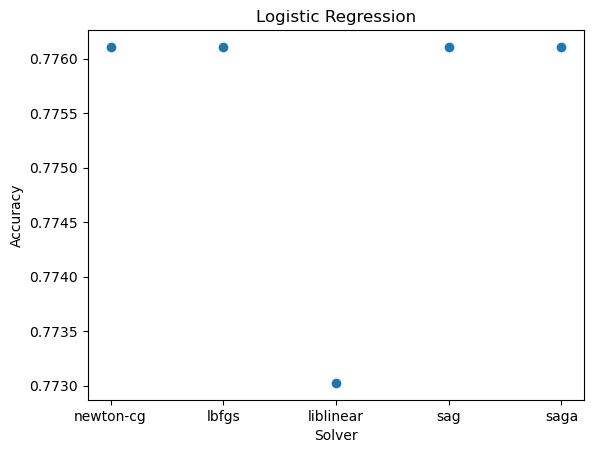

In [324]:
plt.scatter(solvers, accuracies)
plt.xlabel("Solver")
plt.ylabel("Accuracy")
plt.title("Logistic Regression")
plt.show()

- Support Vector Machines

In [313]:
def run_SVM(X_train, y_train, X_test, y_test, gamma_range=[1], kernel="rbf"): 
    accuracies = []
    for gamma in gamma_range:
        print(f"Gamma = {gamma}")
        clf = SVC(C=gamma, kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}\n")
    
    return accuracies

In [314]:
gamma_range = [0.1, 1, 10, 100, 1000]
accuracies = run_SVM(X_train, y_train, X_test, y_test, gamma_range)

Gamma = 0.1
Accuracy: 0.7052023121387283

Gamma = 1
Accuracy: 0.7757225433526012

Gamma = 10
Accuracy: 0.7822736030828517

Gamma = 100
Accuracy: 0.7572254335260116

Gamma = 1000
Accuracy: 0.7564547206165704



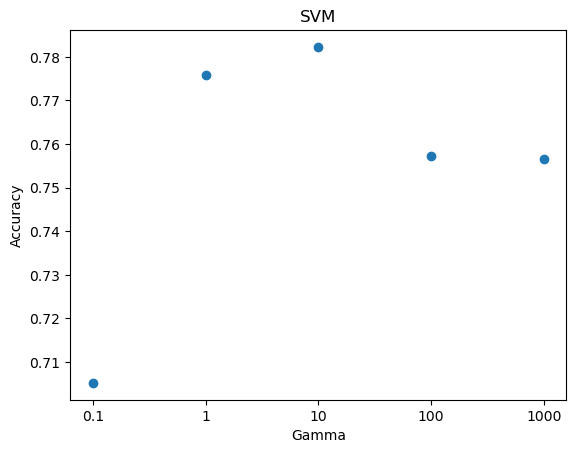

In [315]:
plt.scatter([str(gamma) for gamma in gamma_range], accuracies)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("SVM")
plt.show()

- K-nearest neighbor

In [347]:
def run_KNN(X_train, y_train, X_test, y_test, k_range): 
    accuracies = []
    
    for k in range(1, k_range + 1, 2):
        print(f'k = {k}', end="\r")
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return accuracies

In [348]:
k = 50
accuracies = run_KNN(X_train, y_train, X_test, y_test, k_range=k)

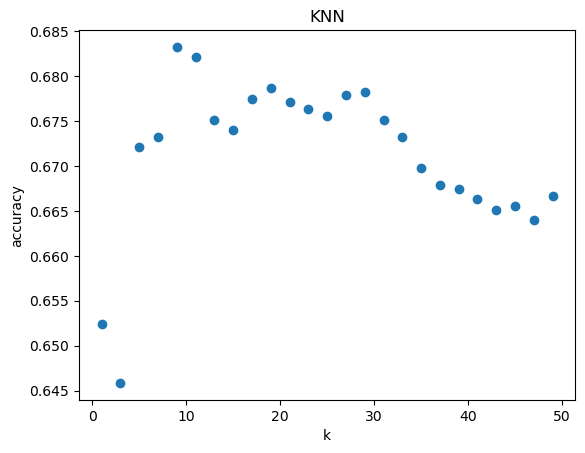

In [349]:
x = np.array(list(range(1, k + 1, 2)), dtype=np.int8)

plt.scatter(x, accuracies)
plt.title("KNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

In [350]:
print(f"Highest accuracy (knn): {max(accuracies)}")

Highest accuracy (knn): 0.6832369942196532


### Report

As we can see, the model with the highest accuracy on our data is a Support Vector Machine. All of the models performed relatively on the same level. The model with the least performance is K-Nearest Neighbor Classifier. Logistic Regression and Support Vector Machines performed well and almost on the same level.<br><br>

Best Model Accuracy: **SVM** with **GAMMA=10**